In [19]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit
from pixelgrid import *
from psfmodel import *

In [20]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [58]:
reduce = 1

#%% obs grid
Nx, Ny = 30 / reduce, 30 / reduce
pix = PixelGrid(0, Nx, 0, Ny)

#%% true grid (oversample)
oversample_true = 10
spix = PixelGrid(0, Nx, 0, Ny, dx=1./oversample_true, dy=1./oversample_true)

In [59]:
M, N = spix.X.shape
K, L = oversample_true, oversample_true
MK, NL = M // K, N // L
@jit
def super_to_obs(Zsuper):
    return Zsuper[:MK*K, :NL*L].reshape(MK, K, NL, L).sum(axis=(1, 3))

In [60]:
truepsffunc = gaussian_psf

In [61]:
xcenters = np.array([15., 24.2]) / reduce
ycenters = np.array([19.2, 5.5]) / reduce
#xcenters = np.array([15., 24.2, 5.4, 7.3]) / reduce
#ycenters = np.array([19.2, 5.5, 6.0, 22.]) / reduce
truepsfkws = {"sigma": 1. / reduce}

In [62]:
def simage(spix, xcenters, ycenters, psffunc, **kwargs):
    ret = np.zeros_like(spix.X)
    for x, y in zip(xcenters, ycenters):
        sZ = truepsffunc(spix.X, spix.Y, x, y, **kwargs)
        ret += sZ / jnp.sum(sZ)
    return np.array(ret)

In [63]:
Zs = simage(spix, xcenters, ycenters, truepsffunc, **truepsfkws)

In [64]:
def plot2d(Z, pix, xcenters=None, ycenters=None, title=None):
    plt.imshow(Z, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    plt.xlabel("x pixel")
    plt.ylabel("y pixel")
    if xcenters is not None:
        for x, y in zip(xcenters, ycenters):
            plt.axvline(x=x, color='gray', lw=1, alpha=0.5)
            plt.axhline(y=y, color='gray', lw=1, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.colorbar();

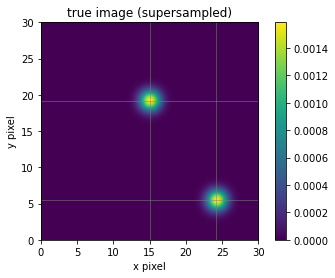

In [65]:
plot2d(Zs, spix, xcenters=xcenters, ycenters=ycenters, title="true image (supersampled)")

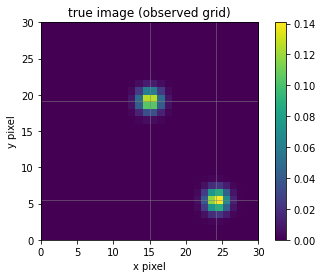

In [66]:
Z = super_to_obs(Zs)
plot2d(Z, pix, xcenters=xcenters, ycenters=ycenters, title="true image (observed grid)")

In [67]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*np.shape(Z))*sigmaerr
Zobs = Z + Zerr

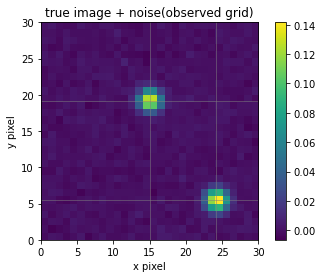

In [68]:
plot2d(Zobs, pix, xcenters=xcenters, ycenters=ycenters, title="true image + noise(observed grid)")

In [69]:
def gpmodel(Z, sigmaerr, xcenters, ycenters):
    ones = jnp.ones_like(xcenters)
    
    #c = numpyro.sample("c", dist.TruncatedNormal(loc=ones, scale=ones, low=ones*0.))
    x = numpyro.sample("x", dist.Uniform(low=xcenters[1:]-3, high=xcenters[1:]+3))
    y = numpyro.sample("y", dist.Uniform(low=ycenters[1:]-3, high=ycenters[1:]+3))
    xc = jnp.r_[xcenters[0], x]
    yc = jnp.r_[ycenters[0], y]
   
    lnlenx = numpyro.sample("lnlenx", dist.Uniform(low=-2, high=3))
    lnleny = numpyro.sample("lnleny", dist.Uniform(low=-2, high=3))
    lna = numpyro.sample("lna", dist.Uniform(low=-2, high=2))
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    
    Rs = jnp.array([pix.X1d[:,jnp.newaxis]-xc, pix.Y1d[:,jnp.newaxis]-yc])
    d0sq = jnp.sum(Rs[:,:,0]**2, axis=0)
    d1sq = jnp.sum(Rs[:,:,1]**2, axis=0)
    idx0 = d0sq < d1sq
    Rvect = jnp.where(idx0, Rs[:,:,0], Rs[:,:,1])
    dRvect = Rvect[:,:,None] - Rvect[:,None,:]
    dx2 = jnp.power(dRvect[0] / lenx, 2.0)
    dy2 = jnp.power(dRvect[1] / leny, 2.0)
    kernel = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)
    
    #lnsigma = numpyro.sample("lnsigma", dist.Uniform(-10, -5))
    kernel += sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    numpyro.deterministic("kernel", kernel)
    
    mv = dist.MultivariateNormal(loc=jnp.zeros(pix.Nx*pix.Ny), covariance_matrix=kernel)
    #alphas = numpyro.sample("alphas", mv)
    
    numpyro.sample("obs", mv, obs=Z.ravel())
    
    """
    Zpsf_model = gpsfvalues(spix.X, spix.Y, xc, yc, jnp.exp(alphas)) 
    Zpsf_model = jnp.sum(Zpsf_model / jnp.sum(Zpsf_model, axis=(1,2))[:,None, None] * c[:,None,None], axis=0)
    Zpsf_obs = numpyro.deterministic("Zpsf_obs", super_to_obs(Zpsf_model))

    numpyro.sample("obs", dist.Normal(Zpsf_obs, sigmaerr), obs=Z)
    """

In [70]:
kernel = numpyro.infer.NUTS(gpmodel)

In [71]:
nw, ns = 500, 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [72]:
rng_key = random.PRNGKey(0)

In [73]:
mcmc.run(rng_key, Zobs, sigmaerr, xcenters, ycenters)

  0%|                                                                                                              | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|███████████████████████████████████████████████| 1000/1000 [26:15<00:00,  1.58s/it, 127 steps of size 2.01e-02. acc. prob=0.76]
2022-07-15 14:30:31.062512: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.02GiB (rounded to 3240000000)requested by op 
2022-07-15 14:30:31.063200: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] *********************************************************_________________________________

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3240000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    3.02GiB
              constant allocation:         0B
        maybe_live_out allocation:    3.02GiB
     preallocated temp allocation:         0B
                 total allocation:    6.03GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 3.02GiB
		Entry Parameter Subshape: f64[500,900,900]
		==========================

	Buffer 2:
		Size: 3.02GiB
		XLA Label: copy
		Shape: f64[1,500,900,900]
		==========================



In [50]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       lna     -1.99      0.01     -1.99     -2.00     -1.98     79.15      1.01
    lnlenx      0.10      0.03      0.11      0.05      0.14     17.69      1.14
    lnleny     -1.62      0.21     -1.60     -1.95     -1.31     16.34      1.09
      x[0]      9.69      0.28      9.79      9.14     10.00     38.46      1.00
      y[0]      2.34      0.13      2.37      2.12      2.51     12.35      1.27

Number of divergences: 0


In [51]:
smp = mcmc.get_samples()

In [52]:
from numpyro.infer import Predictive
predictive = Predictive(gpmodel, mcmc.get_samples())

In [53]:
pred = predictive(random.PRNGKey(1), Z=Zobs, sigmaerr=sigmaerr, xcenters=xcenters, ycenters=ycenters)

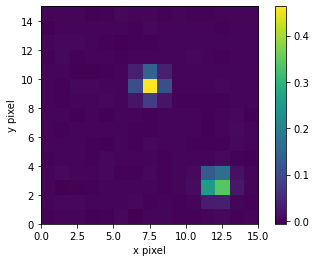

In [54]:
plot2d(Zobs, pix)

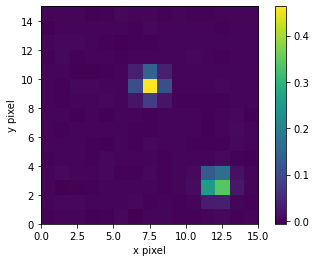

In [55]:
plot2d(np.mean(pred['obs'], axis=0).reshape(15,15), pix)

In [56]:
np.r_[xcenters[1:], ycenters[1:]]

array([12.1 ,  2.75])

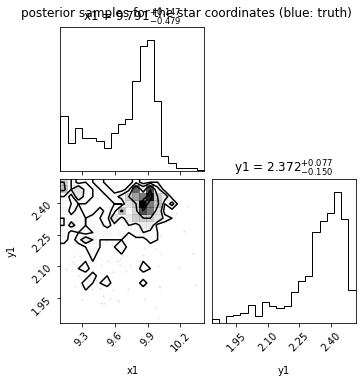

In [57]:
import corner
fig = corner.corner(np.c_[np.array(smp['x']), np.array(smp['y'])], 
                    show_titles=True, title_fmt=".3f",
                    truths=np.r_[xcenters[1:], ycenters[1:]],
                   labels=["x%d"%i for i in range(1,len(xcenters))]+["y%d"%i for i in range(1,len(xcenters))])
fig.suptitle("posterior samples for the star coordinates (blue: truth)");

In [347]:
from tinygp import kernels, GaussianProcess
lna, lenx, leny = 0, 1., 1.
kernel = kernels.ExpSquared(jnp.array([lenx, leny]))
kernel = jnp.exp(2*lna) * kernel

In [348]:
X = jnp.array([pix.X1d, pix.Y1d]).T
gp = GaussianProcess(kernel, X, diag=jnp.exp(-10), mean=0.)

In [350]:
np.diag(gp.covariance_matrix)

array([1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454, 1.0000454,
       1.0000454, 1.0000454, 1.0000454, 1.0000454, 

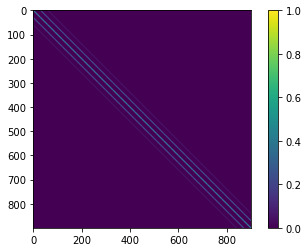

In [324]:
plt.imshow(gp.covariance_matrix)
plt.colorbar()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       lna     -0.09      1.20     -0.03     -1.87      1.73     88.91      0.99
    lnlenx      0.44      1.61      0.37     -1.61      2.94    118.96      1.00
    lnleny      0.37      1.49      0.22     -2.00      2.47    192.22      1.00
   lnsigma     -7.41      1.44     -7.35     -9.48     -5.26    292.15      0.99
      x[0]     24.18      1.60     24.03     21.76     26.91    148.09      1.00
      y[0]      5.46      1.69      5.45      2.95      8.35     96.33      0.99

Number of divergences: 0


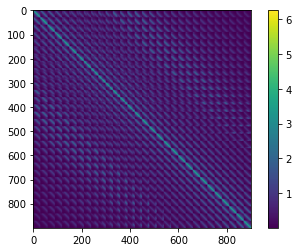